In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, Flatten, Dropout
from keras.utils import to_categorical


url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv"
dataset = pd.read_csv(url, sep=",", names=["duration", "protocoltype", "service", "flag", "srcbytes", "dstbytes", "land", "wrongfragment", "urgent", "hot", "numfailedlogins", "loggedin", "numcompromised", "rootshell", "suattempted", "numroot", "numfilecreations", "numshells", "numaccessfiles", "numoutboundcmds", "ishostlogin", "isguestlogin", "count", "srvcount", "serrorrate", "srvserrorrate", "rerrorrate", "srvrerrorrate", "samesrvrate", "diffsrvrate", "srvdiffhostrate", "dsthostcount", "dsthostsrvcount", "dsthostsamesrvrate", "dsthostdiffsrvrate", "dsthostsamesrcportrate", "dsthostsrvdiffhostrate", "dsthostserrorrate", "dsthostsrvserrorrate", "dsthostrerrorrate", "dsthostsrvrerrorrate", "attack", "level"])

dataset.drop('level', axis=1, inplace=True)
dataset['attack'] = (dataset['attack'] != "normal") * 1

le = LabelEncoder()
dataset['protocoltype'] = le.fit_transform(dataset['protocoltype'])
dataset['service'] = le.fit_transform(dataset['service'])
dataset['flag'] = le.fit_transform(dataset['flag'])

x = dataset.drop(['attack'], axis=1)
y = dataset['attack'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Standardize numerical features using RobustScaler
rScaler = StandardScaler()
x_train = rScaler.fit_transform(x_train)
x_test = rScaler.transform(x_test)

# Define the function to build the autoencoder
def build_autoencoder(input_dim):
    autoencoder = Sequential()
    autoencoder.add(Dense(32, input_dim=input_dim, activation='relu'))
    autoencoder.add(Dense(16, activation='relu'))
    autoencoder.add(Dense(8, activation='relu'))
    autoencoder.add(Dense(16, activation='relu'))
    autoencoder.add(Dense(32, activation='relu'))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))
    return autoencoder

# Prepare data for the autoencoder
x_autoencoder_train, x_autoencoder_test, _, _ = train_test_split(x, y, test_size=0.25, random_state=42)
scaler_autoencoder = StandardScaler()
x_autoencoder_train_scaled = scaler_autoencoder.fit_transform(x_autoencoder_train)
x_autoencoder_test_scaled = scaler_autoencoder.transform(x_autoencoder_test)

# Build and train the autoencoder
autoencoder = build_autoencoder(x_autoencoder_train_scaled.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_autoencoder_train_scaled, x_autoencoder_train_scaled, epochs=10, batch_size=64, shuffle=True, validation_data=(x_autoencoder_test_scaled, x_autoencoder_test_scaled))

# Encode the data using the trained autoencoder
encoded_train = autoencoder.predict(x_train)
encoded_test = autoencoder.predict(x_test)

# Build and train the KNN classifier using the encoded data
k1 = KNeighborsClassifier(n_neighbors=5)
k1.fit(encoded_train, y_train)

k1_predictions = k1.predict(encoded_test)
knn_accuracy = accuracy_score(k1_predictions, y_test)
print("KNN Accuracy:", knn_accuracy)



Epoch 1/10
1477/1477 [==============================] - 9s 5ms/step - loss: 0.7968 - val_loss: 0.6796
Epoch 2/10
1477/1477 [==============================] - 7s 5ms/step - loss: 0.7651 - val_loss: 0.6761
Epoch 3/10
1477/1477 [==============================] - 8s 5ms/step - loss: 0.7621 - val_loss: 0.6740
Epoch 4/10
1477/1477 [==============================] - 7s 5ms/step - loss: 0.7609 - val_loss: 0.6732
Epoch 5/10
1477/1477 [==============================] - 8s 5ms/step - loss: 0.7603 - val_loss: 0.6727
Epoch 6/10
1477/1477 [==============================] - 6s 4ms/step - loss: 0.7601 - val_loss: 0.6727
Epoch 7/10
1477/1477 [==============================] - 8s 5ms/step - loss: 0.7598 - val_loss: 0.6725
Epoch 8/10
1477/1477 [==============================] - 7s 5ms/step - loss: 0.7596 - val_loss: 0.6720
Epoch 9/10
1477/1477 [==============================] - 7s 5ms/step - loss: 0.7577 - val_loss: 0.6656
Epoch 10/10
985/985 [==============================] - 3s 3ms/step
KNN Accuracy: 0

# CNN

In [7]:
x_train_cnn = encoded_train.reshape(encoded_train.shape[0], encoded_train.shape[1], 1)
x_test_cnn = encoded_test.reshape(encoded_test.shape[0], encoded_test.shape[1], 1)

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(encoded_train.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train_cnn, y_train, epochs=5, batch_size=64, validation_data=(x_test_cnn, y_test))


cnn_score = cnn_model.evaluate(x_test_cnn, y_test)
print("CNN Accuracy:", cnn_score[1])


Epoch 1/5
1477/1477 [==============================] - 13s 8ms/step - loss: 0.1463 - accuracy: 0.9449 - val_loss: 0.1138 - val_accuracy: 0.9542
Epoch 2/5
1477/1477 [==============================] - 13s 9ms/step - loss: 0.1191 - accuracy: 0.9565 - val_loss: 0.1044 - val_accuracy: 0.9612
Epoch 3/5
1477/1477 [==============================] - 12s 8ms/step - loss: 0.1139 - accuracy: 0.9586 - val_loss: 0.1058 - val_accuracy: 0.9599
Epoch 4/5
1477/1477 [==============================] - 15s 10ms/step - loss: 0.1108 - accuracy: 0.9598 - val_loss: 0.1020 - val_accuracy: 0.9619
Epoch 5/5
985/985 [==============================] - 4s 4ms/step - loss: 0.0967 - accuracy: 0.9644
CNN Accuracy: 0.9643741846084595


# Naive Bayes

In [20]:

naive_bayes_classifier = GaussianNB()

naive_bayes_classifier.fit(encoded_train, y_train)

y_pred = naive_bayes_classifier.predict(encoded_test)

accuracy1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy1)

print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8842636692703372
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     16774
           1       0.92      0.83      0.87     14720

    accuracy                           0.88     31494
   macro avg       0.89      0.88      0.88     31494
weighted avg       0.89      0.88      0.88     31494



# Random forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_classifier.fit(encoded_train, y_train)

y_pred1 = random_forest_classifier.predict(encoded_test)

accuracy = accuracy_score(y_test, y_pred1)
print("Random Forest Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9939988569251286
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     16774
           1       0.92      0.83      0.87     14720

    accuracy                           0.88     31494
   macro avg       0.89      0.88      0.88     31494
weighted avg       0.89      0.88      0.88     31494



In [21]:
results = pd.DataFrame(columns=['Algorithme', 'Accuracy'])

knn_accuracy = accuracy_score(k1_predictions, y_test)
results = results.append({'Algorithme': 'KNN', 'Accuracy': knn_accuracy}, ignore_index=True)

Random_Forest_accuracy = accuracy_score(y_test, y_pred1)
results = results.append({'Algorithme': 'Random Forest', 'Accuracy': Random_Forest_accuracy}, ignore_index=True)

cnn_accuracy = cnn_score[1]
results = results.append({'Algorithme': 'CNN', 'Accuracy': cnn_accuracy}, ignore_index=True)

naive_bayes_accuracy = accuracy1
results = results.append({'Algorithme': 'Naive Bayes', 'Accuracy': naive_bayes_accuracy}, ignore_index=True)

print(results)


      Algorithme  Accuracy
0            KNN  0.988347
1  Random Forest  0.993999
2            CNN  0.964374
3    Naive Bayes  0.884264


C:\Users\DELL\AppData\Local\Temp\ipykernel_21444\2125283383.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Algorithme': 'KNN', 'Accuracy': knn_accuracy}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21444\2125283383.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Algorithme': 'Random Forest', 'Accuracy': Random_Forest_accuracy}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21444\2125283383.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Algorithme': 'CNN', 'Accuracy': cnn_accuracy}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21444\2125283383.py:18: FutureWarning: The frame.appe

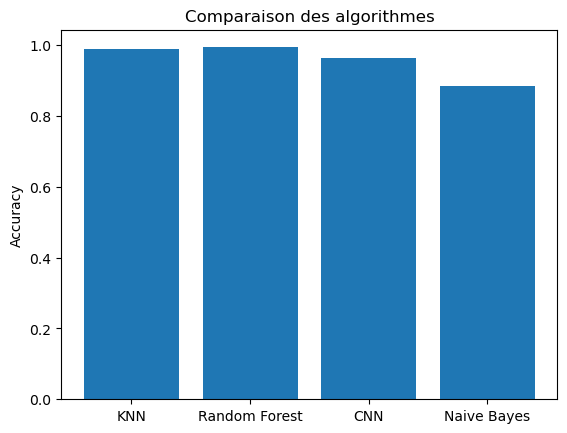

In [22]:
import matplotlib.pyplot as plt

plt.bar(results['Algorithme'], results['Accuracy'])
plt.ylabel('Accuracy')
plt.title('Comparaison des algorithmes')
plt.show()